In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import healpy as hp
import reproject
import numpy as np
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from spectral_cube import SpectralCube
import spectral_cube.utils
import warnings

This notebook plots the spectra of GMIMS HBN (DRAO 26-m), CHIME, Dragons, and Dwingeloo in various ways

In [11]:
gmims_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/GMIMS-HBN_fanregion_cutout_pI.fits', format='fits')
chime_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/chimepI_kelvin_tadpolecutout.fits')
drago_cube = SpectralCube.read('/srv/nmohamme/fanregionII/data/dragons_pI_kelvin.fits')

hdr_hbn = fits.getheader('/srv/nmohamme/fanregionII/data/GMIMS-HBN_fanregion_cutout_pI.fits')
wcs_hbn=WCS(hdr_hbn)
hdr_chime = fits.getheader('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/Q_400_729_Mar2024_tadpole_gal.fits')
wcs_chime=WCS(hdr_chime)

In [12]:
k_B = 1.380649e-23
def do_dwingeloo(freq='1411', LOS=[1, 1]):
    """ 
    Read the Dwingeloo data and returns dicionary of intensities at desired frequency & at the specific LOS
    
    Allowed Frequencies: 410, 465, 610, 820, 1411 #MHz
    
    """
    l_list = []
    b_list = []
    ra_list = []
    dec_list = []
    PI_list = []
    gal_theta_list = []
    eq_theta_list = []
    
    fn = '/srv/data/dwingeloo_data/original/out' + freq

    with open(fn) as f:
        for line in f:
            line = f.readline()
            l_list.append(float(line[0:7]))
            b_list.append(float(line[7:13]))
            ra_list.append(float(line[13:19]))
            dec_list.append(float(line[19:25]))
            PI_list.append(float(line[25:31]))
            gal_theta_list.append(float(line[31:37]))
            eq_theta_list.append(float(line[37:43]))

    f.close()

    l_arr = np.asarray(l_list)*u.deg
    b_arr = np.asarray(b_list)*u.deg
    b_arr[b_arr > 180*u.deg] -= 360*u.deg

    l_pix = wcs_chime.wcs_world2pix(l_arr, b_arr, 1, 1)[0] #Pixel coordinates of the Dwingeloo data on CHIME WCS
    b_pix = wcs_chime.wcs_world2pix(l_arr, b_arr, 1, 1)[1]
    
    j = int(np.argmin(np.abs(l_pix-LOS[0])+np.abs(b_pix-LOS[1]))) #Index of the closest pixel to the LOS
    
    Iv = 2*(int(freq)*1e6)**2*k_B*np.asarray(PI_list)/3e8**2/1e-26 #Specific intensity as a function of frequency
    Il = 2*3e8*k_B*np.asarray(PI_list)/(3e8/(int(freq)*1e6))**4 #Specific intensity as a function of lambda
    
    return {'pI':PI_list[j], 'Iv':Iv[j], 'Il':Il[j]}#, 'j':j}
                        
    
    

In [13]:
dwi_keys = ['408', '465', '610', '820', '1411'] #used to index the returned dictionary of do_dwingeloo
dwi_freq = np.asarray([0.408,0.465,0.610,0.820,1.411])*u.GHz #Frequencies for plotting scatter of dwingeloo data

In [14]:
file_path = '/srv/data/dragons/Mar2024_500_1000_MHz_cube/ListOfFrequencies_Hz.txt'
drag_freq = np.loadtxt(file_path)

#dragons spectra bc WCS is incorrect, so use drag_freq for plotting/getting correct frequencies

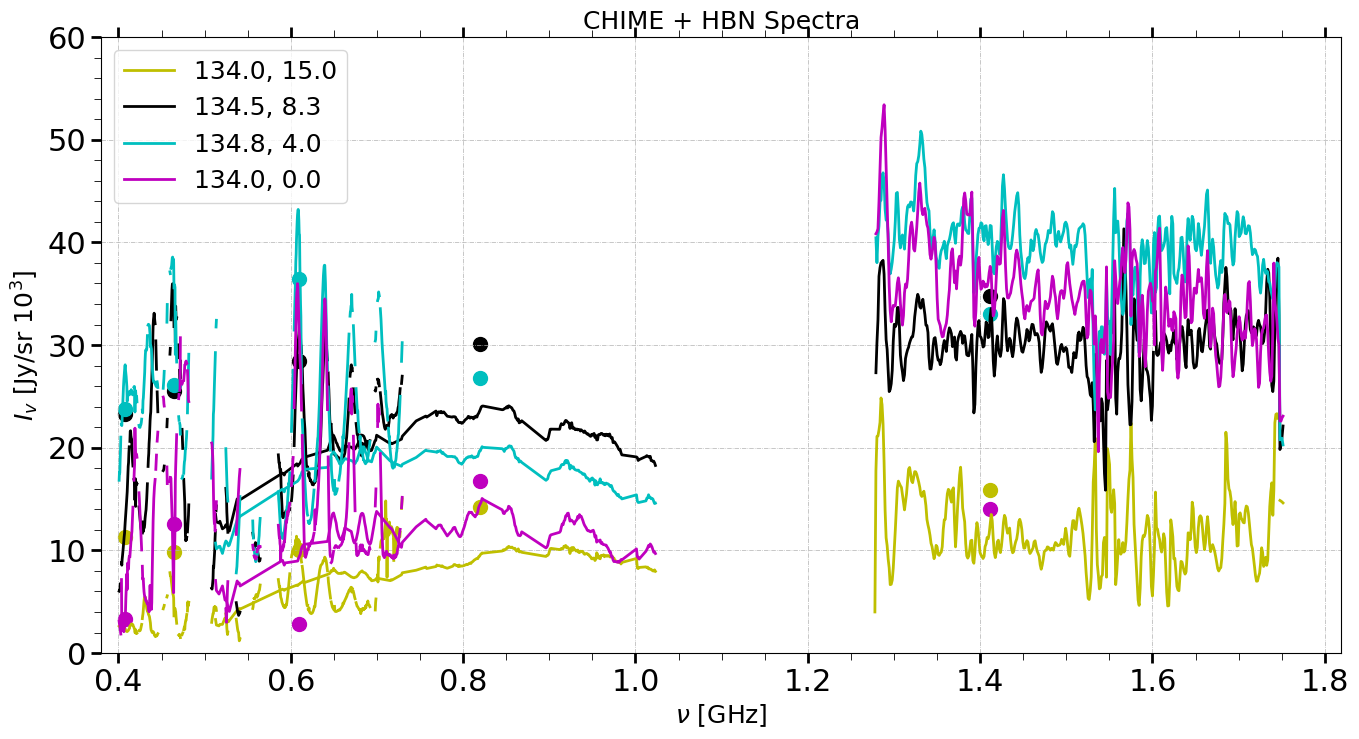

In [7]:
warnings.filterwarnings("ignore", message="PossiblySlowWarning")
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Slicing across a celestial axis results in an invalid WCS")
warnings.filterwarnings("ignore", category=spectral_cube.utils.PossiblySlowWarning)
#^ Just to stop it from spitting out annoying warnings

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
all_freq = np.arange(1e-3, 2, 1e-3)

clist = SkyCoord([134,134.5,134.8,134]*u.deg, [15.0,8.3,4.0,0.0]*u.deg, frame='galactic')

for c, color in zip(clist, ['y', 'k', 'c', 'm']):
    
    LOS=[int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[0][0]),int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[1][0])]
    
    dwi = {}
    dwi['408']=do_dwingeloo(freq='408', LOS=LOS)
    dwi['465']=do_dwingeloo(freq='465', LOS=LOS)
    dwi['610']=do_dwingeloo(freq='610', LOS=LOS)
    dwi['820']=do_dwingeloo(freq='820', LOS=LOS)
    dwi['1411']=do_dwingeloo(freq='1411', LOS=LOS)
                         


    region=(40*u.arcmin).to(u.deg)
    r=gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                  ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K=np.median(r.with_mask(r > 0.05*u.K).median(axis=1).value, axis=1) * r.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r.spectral_axis))
    
    
    r2=chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
    chime_spectrum_K=np.median(r2.with_mask(r2>0.05*u.K).median(axis=1).value, axis=1)*r2.unit
    chime_spectrum_Jy_sr=chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r2.spectral_axis))

    r3=drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(r3.with_mask(r3>0.05*u.K).median(axis=1).value, axis=1)*r3.unit
    drago_spectrum_Jy_sr=drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))
    
    
    
    

    ax.plot(r.spectral_axis.to(u.GHz), gmims_spectrum_Jy_sr/1e3, c=color, lw=2, label=f'{c.galactic.l.value}, {c.galactic.b.value}')
    ax.plot(r2.spectral_axis.to(u.GHz), chime_spectrum_Jy_sr/1e3, c=color, lw=2)
    ax.plot(drag_freq*u.Hz.to(u.GHz), drago_spectrum_Jy_sr/1e3, c=color, lw=2)
    ax.scatter(dwi_freq, np.asarray([dwi[key]['Iv'] for key in dwi_keys])/1e3, c=color, s=100)
    
ax.set_ylabel(r'$I_v$ [Jy/sr $10^3$]', fontsize=18)
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
ax.set_ylim(0,60)
ax.set_xlim(0.38)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title('CHIME + HBN Spectra', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)



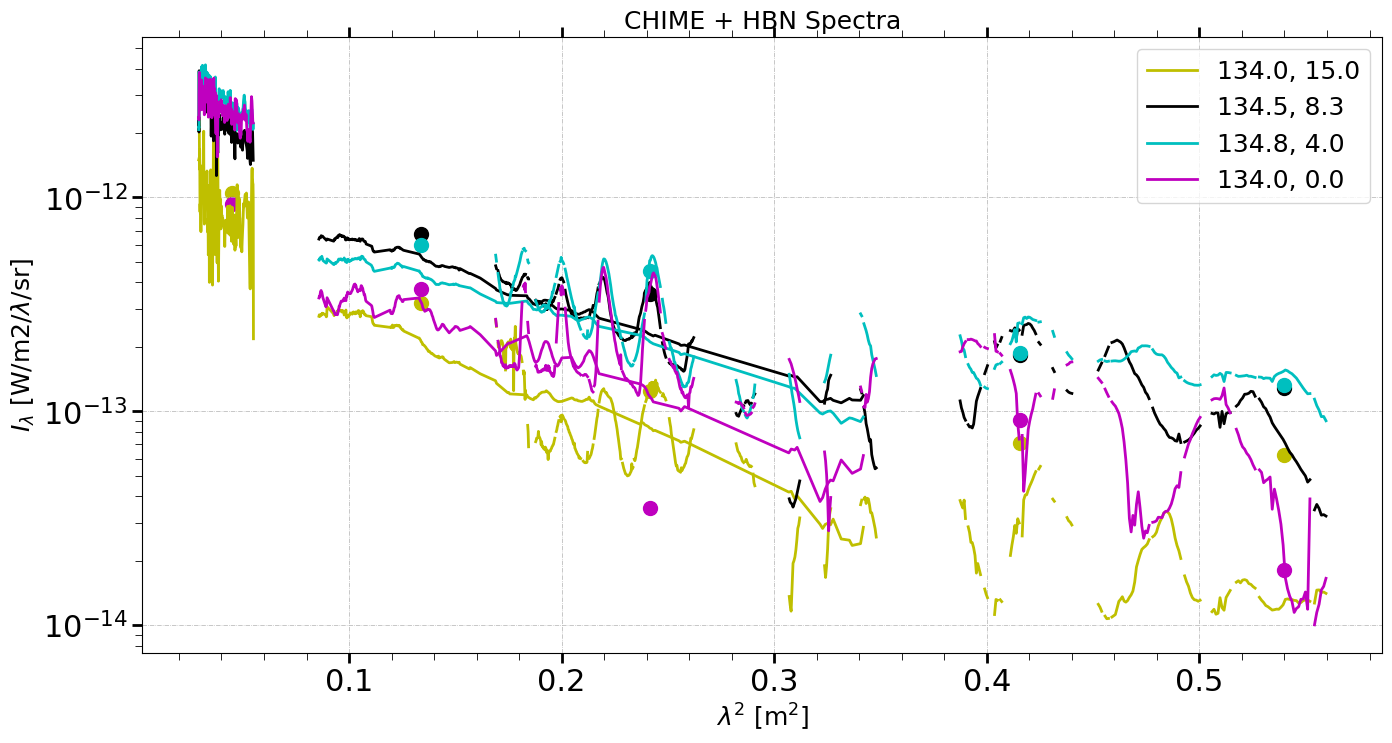

In [9]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
all_freq = np.arange(1e-3, 2, 1e-3)

clist = SkyCoord([134,134.5,134.8,134]*u.deg, [15.0,8.3,4.0,0.0]*u.deg, frame='galactic')

for c, color in zip(clist, ['y', 'k', 'c', 'm']):
    
    LOS=[int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[0][0]),int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[1][0])]
    
    dwi = {}
    dwi['408']=do_dwingeloo(freq='408', LOS=LOS)
    dwi['465']=do_dwingeloo(freq='465', LOS=LOS)
    dwi['610']=do_dwingeloo(freq='610', LOS=LOS)
    dwi['820']=do_dwingeloo(freq='820', LOS=LOS)
    dwi['1411']=do_dwingeloo(freq='1411', LOS=LOS)
                         


    region=(40*u.arcmin).to(u.deg)
    
    r=gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K=np.median(r.with_mask(r > 0.05*u.K).median(axis=1).value, axis=1) * r.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r.spectral_axis))
    gmims_spectrum_I_lambda = 2*3e8*k_B*gmims_spectrum_K.value/r.spectral_axis.to(u.m, equivalencies=u.spectral()).value**4
    
    
    r2=chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2, ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
    chime_spectrum_K=np.median(r2.with_mask(r2>0.05*u.K).median(axis=1).value, axis=1)*r2.unit
    chime_spectrum_Jy_sr=chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r2.spectral_axis))
    chime_spectrum_I_lambda = 2*3e8*k_B*chime_spectrum_K.value/r2.spectral_axis.to(u.m, equivalencies=u.spectral()).value**4
    
    r3=drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(r3.with_mask(r3>0.05*u.K).median(axis=1).value, axis=1)*r3.unit
    drago_spectrum_Jy_sr=drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))
    drago_spectrum_I_lambda = 2*3e8*k_B*drago_spectrum_K.value/((drag_freq*u.Hz).to(u.m, equivalencies=u.spectral())).value**4
    
    

    ax.plot(   (r.spectral_axis.to(u.m, equivalencies=u.spectral()).value)**2 , gmims_spectrum_I_lambda, c=color, lw=2, label=f'{c.galactic.l.value}, {c.galactic.b.value}')
    ax.plot(   (r2.spectral_axis.to(u.m, equivalencies=u.spectral()).value)**2, chime_spectrum_I_lambda, c=color, lw=2)
    ax.plot(   ((drag_freq*u.Hz).to(u.m, equivalencies=u.spectral()).value)**2 , drago_spectrum_I_lambda, c=color, lw=2)
    ax.scatter((dwi_freq.to(u.m, equivalencies=u.spectral()).value)**2     , np.asarray([dwi[key]['Il'] for key in dwi_keys]), c=color, s=100)
    
ax.set_ylabel(r'$I_{\lambda}$ [W/m2/$\lambda$/sr]', fontsize=18)
ax.set_xlabel(r'$\lambda^{2}$ [m$^{2}$]', fontsize=18)
#ax.set_ylim(0,60)
#ax.set_xlim(0.2)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title('CHIME + HBN Spectra', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.set_yscale('log')
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)

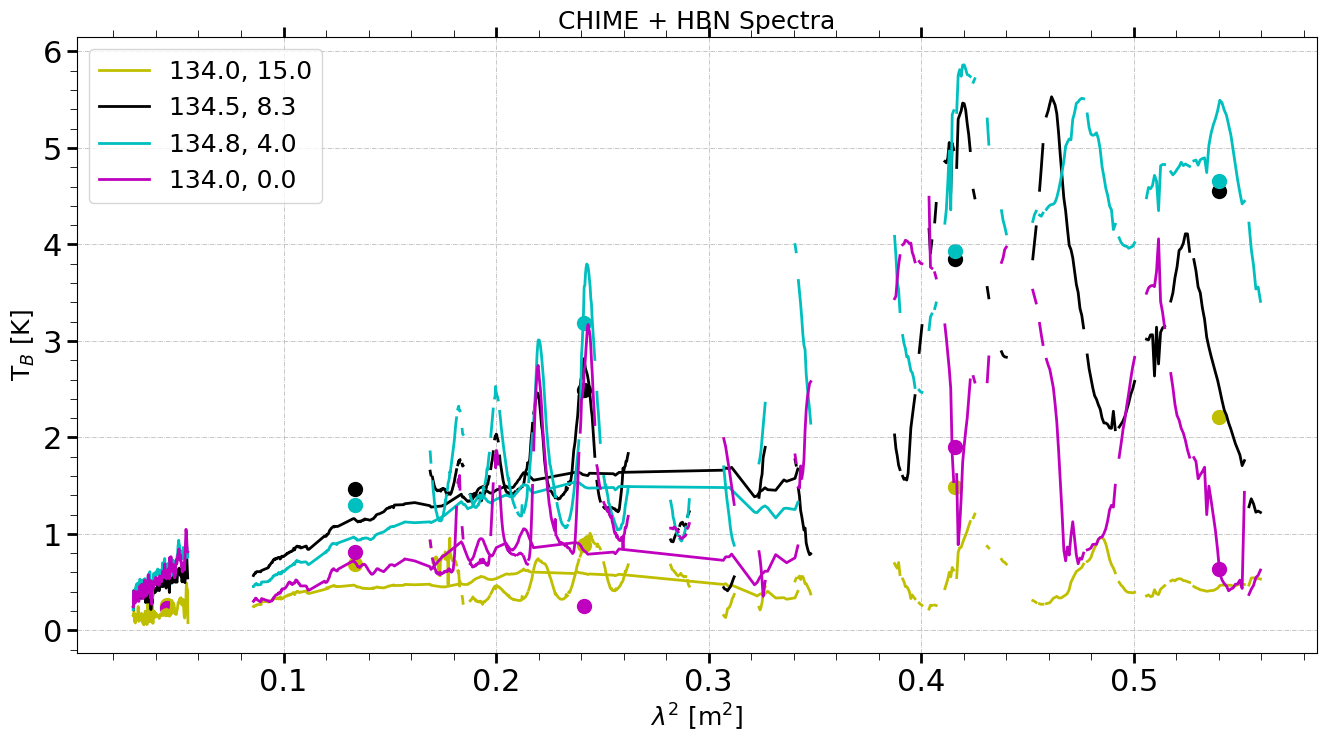

In [25]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
all_freq = np.arange(1e-3, 2, 1e-3)

clist = SkyCoord([134,134.5,134.8,134]*u.deg, [15.0,8.3,4.0,0.0]*u.deg, frame='galactic')

for c, color in zip(clist, ['y', 'k', 'c', 'm']):
    
    LOS=[int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[0][0]),int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[1][0])]
    
    dwi = {}
    dwi['408']=do_dwingeloo(freq='408', LOS=LOS)
    dwi['465']=do_dwingeloo(freq='465', LOS=LOS)
    dwi['610']=do_dwingeloo(freq='610', LOS=LOS)
    dwi['820']=do_dwingeloo(freq='820', LOS=LOS)
    dwi['1411']=do_dwingeloo(freq='1411', LOS=LOS)
                         


    region=(40*u.arcmin).to(u.deg)
    r=gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                  ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K=np.median(r.with_mask(r > 0.05*u.K).median(axis=1).value, axis=1) * r.unit


    
    
    r2=chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
    chime_spectrum_K=np.median(r2.with_mask(r2>0.05*u.K).median(axis=1).value, axis=1)*r2.unit
    
    r3=drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(r3.with_mask(r3>0.05*u.K).median(axis=1).value, axis=1)*r3.unit

    

    ax.plot((r.spectral_axis.to(u.m, equivalencies=u.spectral()).value)**2, gmims_spectrum_K, c=color, lw=2, label=f'{c.galactic.l.value}, {c.galactic.b.value}')
    ax.plot((r2.spectral_axis.to(u.m, equivalencies=u.spectral()).value)**2, chime_spectrum_K, c=color, lw=2)
    ax.plot(((drag_freq*u.Hz).to(u.m, equivalencies=u.spectral()).value)**2     , drago_spectrum_K, c=color, lw=2)
    ax.scatter((dwi_freq.to(u.m, equivalencies=u.spectral()).value)**2, np.asarray([dwi[key]['pI'] for key in dwi_keys]), c=color, s=100)
    
ax.set_ylabel(r'T$_B$ [K]', fontsize=18)
ax.set_xlabel(r'$\lambda^2$ [m$^2$]', fontsize=18)
#ax.set_ylim(0,60)
#ax.set_xlim(0.2)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title('CHIME + HBN Spectra', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
#ax.set_yscale('log')
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)

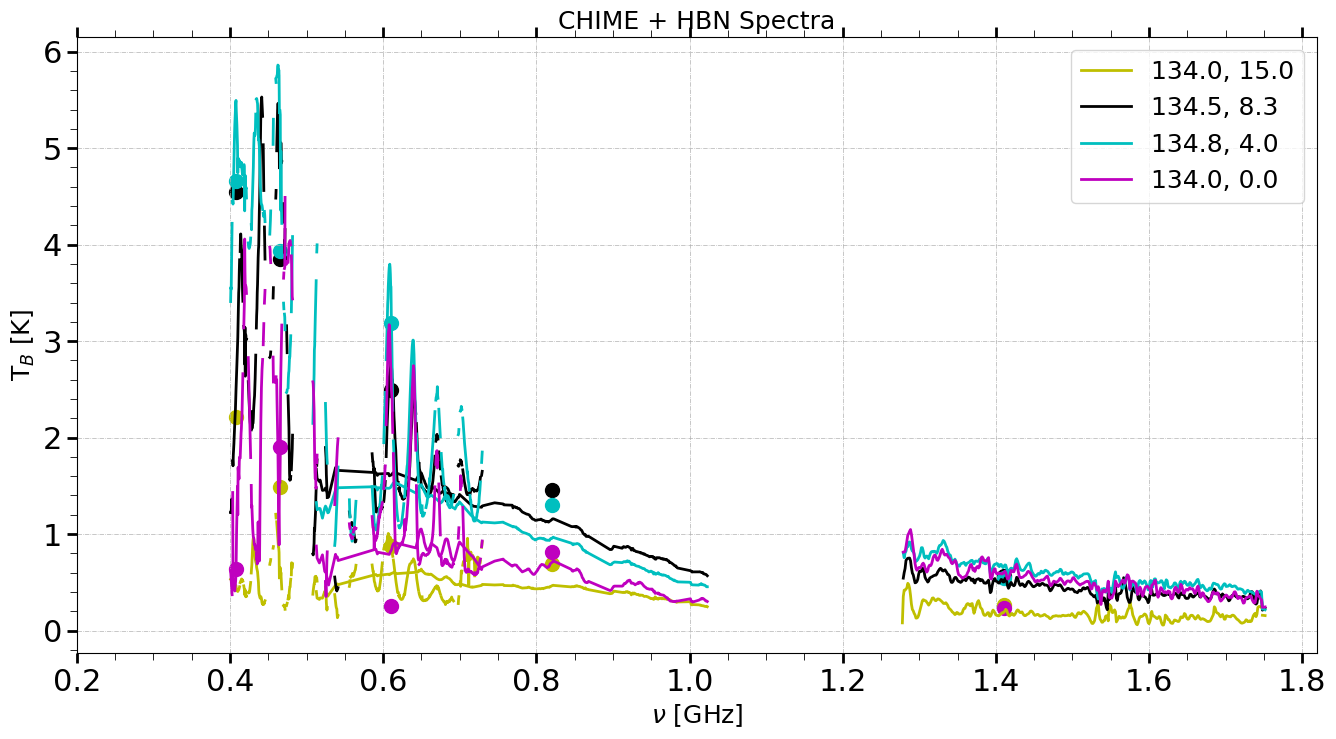

In [27]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
all_freq = np.arange(1e-3, 2, 1e-3)

clist = SkyCoord([134,134.5,134.8,134]*u.deg, [15.0,8.3,4.0,0.0]*u.deg, frame='galactic')

for c, color in zip(clist, ['y', 'k', 'c', 'm']):
    
    LOS=[int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[0][0]),int(wcs_chime.wcs_world2pix([c.galactic.l.value], [c.galactic.b.value], 1, 1)[1][0])]
    
    dwi = {}
    dwi['408']=do_dwingeloo(freq='408', LOS=LOS)
    dwi['465']=do_dwingeloo(freq='465', LOS=LOS)
    dwi['610']=do_dwingeloo(freq='610', LOS=LOS)
    dwi['820']=do_dwingeloo(freq='820', LOS=LOS)
    dwi['1411']=do_dwingeloo(freq='1411', LOS=LOS)
                         


    region=(40*u.arcmin).to(u.deg)
    r=gmims_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                  ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)
    gmims_spectrum_K=np.median(r.with_mask(r > 0.05*u.K).median(axis=1).value, axis=1) * r.unit
    gmims_spectrum_Jy_sr = gmims_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r.spectral_axis))
    
    
    r2=chime_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)*u.K
    chime_spectrum_K=np.median(r2.with_mask(r2>0.05*u.K).median(axis=1).value, axis=1)*r2.unit
    chime_spectrum_Jy_sr=chime_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(r2.spectral_axis))
    
    
    r3=drago_cube.subcube(xlo=c.galactic.l-region/2, xhi=c.galactic.l+region/2,
                      ylo=c.galactic.b-region/2, yhi=c.galactic.b+region/2,)/u.Jy*u.beam*u.K
    drago_spectrum_K = np.median(r3.with_mask(r3>0.05*u.K).median(axis=1).value, axis=1)*r3.unit
    drago_spectrum_Jy_sr=drago_spectrum_K.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(drag_freq*u.Hz))
    
    

    ax.plot(r.spectral_axis.to(u.GHz), gmims_spectrum_K, c=color, lw=2, label=f'{c.galactic.l.value}, {c.galactic.b.value}')
    ax.plot(r2.spectral_axis.to(u.GHz), chime_spectrum_K, c=color, lw=2)
    ax.plot(    drag_freq*u.Hz.to(u.GHz) , drago_spectrum_K, c=color, lw=2)
    
    ax.scatter(dwi_freq, np.asarray([dwi[key]['pI'] for key in dwi_keys]), c=color, s=100)
    
ax.set_ylabel(r'T$_B$ [K]', fontsize=18)
ax.set_xlabel(r'$\nu$ [GHz]', fontsize=18)
#ax.set_ylim(0,60)
ax.set_xlim(0.2)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title('CHIME + HBN Spectra', fontsize=18)
ax.minorticks_on()  # Enable minor ticks for the first subplot
ax.grid(which='major', linestyle='-.', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=22, zorder=30, length=7, width=2, top=True)
ax.tick_params(axis='both', which='minor', length=5, top=True)
plt.legend(fontsize=18)